# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


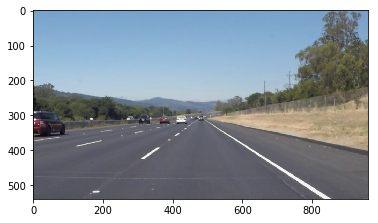

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
%ls

debug_challenge_images/  README.md            testp.py
examples/                test_image_backup/   test_videos/
LaneLines_writeup.md     test_images/         test_videos_output/
P1.ipynb                 test_images_output/  writeup_template.md


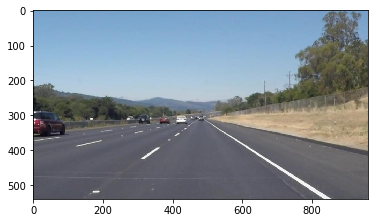

In [4]:
import scipy.misc as mc
mc.imsave('test_images_output/save_test_image.jpg',image)
# plt.imsave('test_images_output/save_test_image.jpg',image)
im = mpimg.imread('test_images_output/save_test_image.jpg')
plt.imshow(im)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, 2)
#     #define x and y dimentional containers for left lane and right lane respectively
    x_l = []
    y_l = []
    x_r = []
    y_r = []
    
    # we need two slope watchdogs to keep filter the poins of left lane and right lane
    # as the image is read vertically inversed, the slopes are negative 
    # for left lane and verse versa for the right one
    slope_v = 1# initial left slope, right slope and slope value with fake values
    #iterate to get all points categorized to left and right
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2==x1:# in case for horizontal line
                continue
            if y2==y1:
                continue
                
            slope_v = (y2-y1)/(x2-x1)
            if slope_v < 0:
                x_l.extend([x1,x2]) #add to left lane x container
                y_l.extend([y1,y2])
            else:
                x_r.extend([x1,x2])
                y_r.extend([y1,y2])
                
    #get 1-d lane coefficients
    coe_l = np.polyfit(x_l,y_l,1)
    coe_r = np.polyfit(x_r,y_r,1)
        
    #get straight line slope
    p1_l = np.poly1d(coe_l)
    p1_r = np.poly1d(coe_r)
        
    # get end points for left lane and right lane
    m1,b1 = coe_l # slope and interception for left lane
    m2,b2 = coe_r # slope and interception for right lane
        
    imgshape = img.shape
    y_upper = imgshape[0]*0.6
    y_lower = imgshape[0]
        
    xl_1 = (y_lower-b1)/m1
    xl_2 = (y_upper-b1)/m1
    xr_1 = (y_lower-b2)/m2
    xr_2 = (y_upper-b2)/m2
        
    #draw line
    cv2.line(img, (np.float32(xl_1), np.float32(y_lower)), (np.float32(xl_2), np.float32(y_upper)), color, thickness)
    cv2.line(img, (np.float32(xr_1), np.float32(y_lower)), (np.float32(xr_2), np.float32(y_upper)), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

__Before moving on, I'd like to create the output dir and make a backup image dir in case__

In [7]:
%ls

debug_challenge_images/  README.md            testp.py
examples/                test_image_backup/   test_videos/
LaneLines_writeup.md     test_images/         test_videos_output/
P1.ipynb                 test_images_output/  writeup_template.md


In [8]:
%mkdir test_images_output test_image_backup

In [5]:
%ls

examples/  README.md           test_images/         test_videos/
P1.ipynb   test_image_backup/  test_images_output/  writeup_template.md


__Copy images in test_images to test_image_backup directory__

In [10]:
%cp test_images/*.jpg test_image_backup/

In [5]:
%ls test_images/

solidWhiteCurve.jpg  solidYellowCurve2.jpg  solidYellowLeft.jpg
solidWhiteRight.jpg  solidYellowCurve.jpg   whiteCarLaneSwitch.jpg


Helper function for show picture

In [8]:
# show image
def show_image(im,figsize=(108,192),titles = None):
    if im is not None:
        if isinstance(im, list):
            fig = plt.figure(figsize=figsize)
            rows = len(im)//2+1 if len(im)%2 ==1 else len(im)//2
            for i in range(len(im)):
                sp =fig.add_subplot(rows,2,i+1)
#                 sp.axis('off')
                if titles is not None:
                    sp.set_title(titles[i],fontweight="bold",fontsize=100)
                plt.imshow(im[i])
        else:
            plt.imshow(im)
        plt.show()
    else:
        print('No image!')  

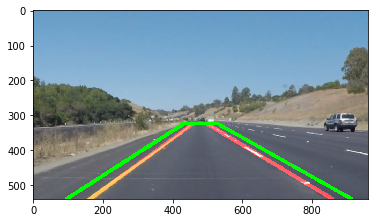

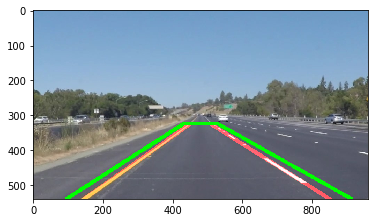

In [9]:
# then save them to the test_images directory.
#load images from folder
images = [] # image containaer
test_image_dir = 'test_images/'
for file_name in os.listdir(test_image_dir):
    img = mpimg.imread(os.path.join(test_image_dir,file_name))
    if img is not None:
        images.append([file_name,img])

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
# Define our parameters for Canny
low_threshold = 50
high_threshold = 150
# Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 300    # maximum gap in pixels between connectable line segments
# line_image = np.copy(image)*0 # creating a blank to draw lines on

# This time we are defining a four sided polygon to mask
imshape = images[0][1].shape
vertices = np.array([[(imshape[1]*0.1,imshape[0]-1),
                      (imshape[1]*0.45, imshape[0]*0.6), 
                      (imshape[1]*0.55, imshape[0]*0.6),
                      (imshape[1]*0.95,imshape[0]-1)]],
                    dtype=np.int32)

#Find the right vertices
#######################################################
# draw lines over an array
def draw_li(img, lines, color=[0, 255, 0], thickness=10):
    for line in lines:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)
        
vert = vertices[0]
ver_m = np.array([[vert[0][0],vert[0][1],vert[1][0],vert[1][1]],
                    [vert[1][0],vert[1][1],vert[2][0],vert[2][1]],
                   [vert[2][0],vert[2][1],vert[3][0],vert[3][1]]])
# draw_li(im_show,ver_m)
#########################################################
     
# imag = images[0]

def draw_lane(img):
    # Read in and grayscale the image
    gray = grayscale(img)
    # apply Gaussian smoothing
    blur_gray = gaussian_blur(gray,kernel_size)
    # apply Canny for color filter
    edges = canny(blur_gray, low_threshold, high_threshold)
    # apply region selection
    masked_edges = region_of_interest(edges, vertices)
    # make a copy of image 
    im_show = np.copy(img)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # Create a "color" binary image to combine with line image
#     color_edges = np.dstack((edges, edges, edges)) 
        # Draw the lines on the edge image
#     lines_edges = weighted_img(color_edges,line_image) 
    lines_edges = weighted_img(im_show,line_image) 
    return lines_edges
# processed =[]
# image_titles = []
for pair in images[:2]:
    filename, image_file = pair
    copy_image_file = np.copy(image_file)
    laned_image = draw_lane(copy_image_file)
    draw_li(laned_image,ver_m)
#     saved_filename = 'lane_lined_'+filename
#     save_file = 'test_images_output/'+saved_filename
#     mc.imsave(save_file,img)
#     saved = mpimg.imread(save_file)
#     show_image(saved)
#     processed.append(laned_image)
#     image_titles.append(filename)
    show_image(laned_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    img = np.copy(image)
    result = draw_lane(img)
    # you should return the final output (image where lines are drawn on lanes)
    return result

Let's try the one with the solid white lane on the right first ...

In [12]:
#load videos from folder
# test_video_dir = 'test_videos/'
# test_video_output = 'test_videos_output/'
# video_path=[]
# for file_name in os.listdir(test_video_dir):
#     v_path = os.path.join(test_video_dir,file_name)
#     if os.path.isfile(v_path):
#         video_path.append([v_path,os.path.join(test_video_output,file_name)])

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
# print(video_path)
# for path in video_path:
#     video_file,output_dir = path
#     clip1 = VideoFileClip(video_file)
#     color_clip = clip1.fl_image(process_image)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(os.path.join(white_output), audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 30.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 14.3 s, sys: 120 ms, total: 14.5 s
Wall time: 7.43 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2_t = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(11,12)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
# clip1.write_images_sequence('test_images/solidYellowLeft_%04d.jpeg', fps=4)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:22<00:00, 31.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 46.7 s, sys: 380 ms, total: 47.1 s
Wall time: 23 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [16]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 19.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 21.8 s, sys: 292 ms, total: 22.1 s
Wall time: 14.9 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### 1. Create a directory to store some captured challenge picture ###

In [18]:
# %mkdir test_videos_output
%mkdir debug_challenge_images
%ls

mkdir: cannot create directory ‘debug_challenge_images’: File exists
debug_challenge_images/  README.md            testp.py
examples/                test_image_backup/   test_videos/
LaneLines_writeup.md     test_images/         test_videos_output/
P1.ipynb                 test_images_output/  writeup_template.md


### 2. Capture some frames for model tuning ### 

In [19]:
clip1 = VideoFileClip("test_videos/challenge.mp4").subclip(4,6)
clip1.write_images_sequence('debug_challenge_images/challenge_%04d.jpeg', fps=4)

[MoviePy] Writing frames debug_challenge_images/challenge_%04d.jpeg.

8it [00:00, 16.88it/s]               

[MoviePy]: Done writing frames debug_challenge_images/challenge_%04d.jpeg.



['debug_challenge_images/challenge_0000.jpeg',
 'debug_challenge_images/challenge_0001.jpeg',
 'debug_challenge_images/challenge_0002.jpeg',
 'debug_challenge_images/challenge_0003.jpeg',
 'debug_challenge_images/challenge_0004.jpeg',
 'debug_challenge_images/challenge_0005.jpeg',
 'debug_challenge_images/challenge_0006.jpeg',
 'debug_challenge_images/challenge_0007.jpeg']

### 3. Tune the model ###

#### 3.1 Load images #### 

In [20]:
#load images from folder
c_images = [] # image containaer
c_image_dir = 'debug_challenge_images/'
for file_name in os.listdir(c_image_dir):
    img = mpimg.imread(os.path.join(c_image_dir,file_name))
    if img is not None:
        c_images.append([file_name,img])

challenge_0006.jpeg


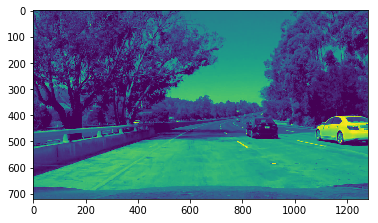

In [21]:
#show one captured image
c_test_image = c_images[3][1]
print(c_images[3][0])
gray_im = grayscale(c_test_image)
# mc.imsave('debug_challenge_images/g_pic.jpg',g_pic)
# r_g_pic = mpimg.imread('debug_challenge_images/g_pic.jpg')
plt.imshow(gray_im)

#### 3.2 Make a copy of all parameters #### 

In [22]:
# Define a kernel size and apply Gaussian smoothing
c_kernel_size = 5
# Define our parameters for Canny
c_low_threshold = 50
c_high_threshold = 150
# Define the Hough transform parameters
c_rho = 1 # distance resolution in pixels of the Hough grid
c_theta = np.pi/180 # angular resolution in radians of the Hough grid
c_threshold = 20     # minimum number of votes (intersections in Hough grid cell)
c_min_line_length = 20 #minimum number of pixels making up a line
c_max_line_gap = 300    # maximum gap in pixels between connectable line segments
# line_image = np.copy(image)*0 # creating a blank to draw lines on

#### 3.3 Detect image shape #### 

In [23]:
c_imshape = c_images[0][1].shape
print('frame dimention of challenge: ',c_imshape)

frame dimention of challenge:  (720, 1280, 3)


In [24]:
print('frame dimention of previous model: ',images[0][1].shape)

frame dimention of previous model:  (540, 960, 3)


> **Evidently, the frame dimention of challenge is different from the previous image or video dimemsion which are all 540*960. We can just simply make some model specific changes to fit challenge, but that will not adapt to other different images or videos. After testing on two resolutions, below is the new vertices scalable to lane line detection: **

In [25]:
# This time we are defining a four sided polygon to mask
c_vertices = np.array([[(c_imshape[1]*0.1,c_imshape[0]-1),
                      (c_imshape[1]*0.45, c_imshape[0]*0.6), 
                      (c_imshape[1]*0.55, c_imshape[0]*0.6),
                      (c_imshape[1]*0.97,c_imshape[0]-1)]],
                    dtype=np.int32)

* **Vertice matrix of our four sided polygon for display**

In [26]:
c_vert = c_vertices[0]
c_ver_m = np.array([[c_vert[0][0],c_vert[0][1],c_vert[1][0],c_vert[1][1]],
                    [c_vert[1][0],c_vert[1][1],c_vert[2][0],c_vert[2][1]],
                   [c_vert[2][0],c_vert[2][1],c_vert[3][0],c_vert[3][1]]])

* **Show result of gray convertion**

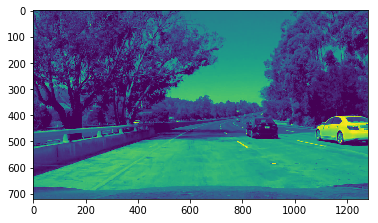

In [27]:
test_pic = np.copy(c_test_image)
show_image(grayscale(test_pic))

* **As showed above, the previous pipeline and parameters work pretty well on solid white images and solid yellow images but very bad on challenge images when driving on complex light environment. So a simple color convertion from rgb to gray cannot give a proper input for the following Canny edge detection which leads to a bad lane line detection result. After reviewing some image processing topics on cv2 tutorials and [some blogs](https://github.com/naokishibuya/car-finding-lane-lines), I got the hint that trying different color space may help for better detect lanes**

_**1.HSV**_

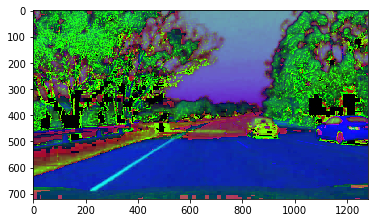

In [28]:
hsv = cv2.cvtColor(test_pic,cv2.COLOR_RGB2HSV)
show_image(hsv)

**We get a clear yellow lane line but not for the while lane line, so we will see another convertion: **

_ **2.HLS** _

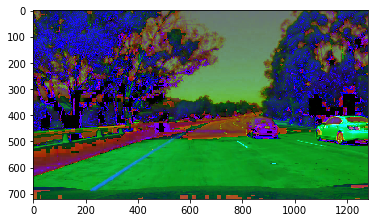

In [29]:
hls = cv2.cvtColor(c_test_image,cv2.COLOR_RGB2HLS)
show_image(hls)

** This time we get a clear white lane line and also yellow lane line. So evidently we'll gonna use HLS to extract lane lines. In addition, we'll need filters for white lane line and yellow(blue in HLS image) lane line.**

In [30]:
def select_yellow_white_lane_line_from_hls(image):
    #convert to HLS image
#     print(image.shape)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #extract white lane line
    white_lower = np.array([0,200,0],dtype='uint8')
    white_higher = np.array([255,255,255],dtype='uint8')
    white_mask = cv2.inRange(hls,white_lower,white_higher)
#     show_image(white_mask)
    #extract yellow lane line
    yellow_lower = np.array([10,0,100],dtype='uint8')
    yellow_higher = np.array([40,255,255],dtype='uint8')
    yellow_mask = cv2.inRange(hls,yellow_lower,yellow_higher)
#     show_image(yellow_mask)
    #put images with lanes masked out together
    masked_lanes = cv2.bitwise_or(white_mask,yellow_mask)
#     show_image(masked_lanes)
    lanes = cv2.bitwise_and(image,image,mask = masked_lanes)
    return lanes

**In fact, I was planning to stop here as the current code was working well for challenge video just coming out several frames of disordered lane lines. But receiving a hint from my mentor which suggested a RGB normalization I will try and see this at the colomn below.**

### 3. Normalization### 

> Color normalization may help to adjust and enhence a raw image for the folow-up processing

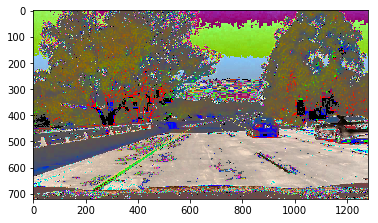

In [31]:
def rgb_normalization(rgb_image):
    norm_image = np.copy(rgb_image) if rgb_image.shape[2]==3 else None
    if norm_image is None:
        print('Input image is not a valid rgb file!')
        return
    r = norm_image[:,:,0]
    g = norm_image[:,:,1]
    b = norm_image[:,:,2]
    color_sum = r + g + b
    
    # normalize respectively for R,G,B
    norm_image[:,:,0] = r/color_sum*255.0
    norm_image[:,:,1] = g/color_sum*255.0
    norm_image[:,:,2] = b/color_sum*255.0
    return norm_image
# test for norm
for ts_i in c_images[:2]:
    _,ts_pic = ts_i
    tem_p = rgb_normalization(ts_pic)
    plt.imshow(tem_p)

_**It seems the normalization works very well for enhence image details, so we are going to apply on the previous pipeline**_

### 4. Pipeline for challenge video ###

In [50]:
def c_draw_lane(img):
    # apply hls convertion and get white yellow lines
    hls_mask =select_yellow_white_lane_line_from_hls(img)
#     show_image(hls_mask)
    # apply color normalization on image
    norm = rgb_normalization(hls_mask)
    # for showing the image, you should uncomment the below line
#     show_image(norm)
    # Read in and grayscale the image
#     hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    c_gray = grayscale(norm)
#     show_image(gray)
    # apply Gaussian smoothing
    cblur_gray = gaussian_blur(gray,kernel_size)
    # apply Canny for color filter
    edges = canny(blur_gray, low_threshold, high_threshold)
    # apply region selection
#     show_image(edges)
    masked_edges = region_of_interest(edges, c_vertices)
    # make a copy of image 
#     im_show = np.copy(img)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # Create a "color" binary image to combine with line image
#     color_edges = np.dstack((edges, edges, edges)) 
        # Draw the lines on the edge image
#     lines_edges = weighted_img(color_edges,line_image) 
    lines_edges = weighted_img(img,line_image) 
    return lines_edges

** Test flow **

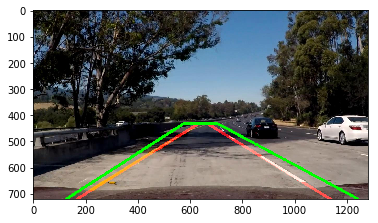

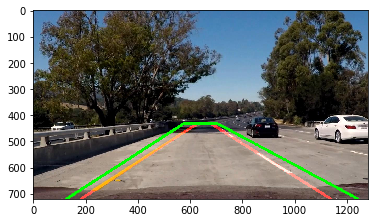

In [51]:
for c_pair in c_images[:2]:
    c_filename, c_image = c_pair
    c_im = np.copy(c_image)
#     print(c_filename)
    c_img = c_draw_lane(c_im)
#     c_img = cv2.cvtColor(c_im,cv2.COLOR_RGB2HSV)
#     c_cann = canny(c_img,low_threshold,high_threshold)
    draw_li(c_img,c_ver_m)
#     saved_filename = 'lane_lined_'+filename
#     save_file = 'test_images_output/'+saved_filename
#     mc.imsave(save_file,img)
#     saved = mpimg.imread(save_file)
#     show_image(saved)
#     c_image_pro.append(c_img)
#     c_image_pro_title.append(c_filename)
    show_image(c_img)

** This time our model fit perfectly the challenge images, so we can move on to retest all videos above.**

### Retry the all three above### 

In [42]:
def c_process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    result = c_draw_lane(image)
    # you shouldnorm return the final output (image where lines are drawn on lanes)
    return result

In [38]:
c_challenge_output = 'test_videos_output/tuned_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge_copy.mp4')
challenge_clip = clip3.fl_image(c_process_image)
%time challenge_clip.write_videofile(c_challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/tuned_challenge.mp4
[MoviePy] Writing video test_videos_output/tuned_challenge.mp4



100%|██████████| 251/251 [00:17<00:00, 14.24it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/tuned_challenge.mp4 

CPU times: user 30.6 s, sys: 380 ms, total: 31 s
Wall time: 19 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(c_challenge_output))

In [49]:
yellow_output = 'test_videos_output/tuned_solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
# clip1.write_images_sequence('test_images/solidYellowLeft_%04d.jpeg', fps=4)
yellow_clip = clip2.fl_image(c_process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

TypeError: expected non-empty vector for x

In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [44]:
c_white_output = 'test_videos_output/tuned_solidWhiteRight.mp4'
c_clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
c_white_clip = c_clip1.fl_image(c_process_image) #NOTE: this function expects color images!!
%time c_white_clip.write_videofile(os.path.join(white_output), audio=False)

TypeError: expected non-empty vector for x

In [179]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))